In [78]:
import os
import glob
import time
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
from externel import seaborn as sns

def bin_CT(img, n_bins=1024):
#     data_vector = np.ravel(img)
    data_max = np.amax(data_vector)
    data_min = np.amin(data_vector)
    # print(data_max, data_min)
    data_squeezed = (data_vector-data_min)/(data_max-data_min)
    data_extended = data_squeezed * n_bins
    data_discrete = data_extended // 1
#     print(data_discrete.shape)
    return np.asarray(list(data_discrete), dtype=np.int64)

train_dict = {}
train_dict["time_stamp"] = time.strftime("%Y-%m-%d_%H:%M:%S", time.localtime())
train_dict["project_name"] = "pixel_correlation"
train_dict["save_folder"] = "./project_dir/"+train_dict["project_name"]+"/"

train_dict["folder_X"] = "./data_dir/norm_MR/regular/"
train_dict["folder_Y"] = "./data_dir/norm_CT_2/regular/"

X_list = sorted(glob.glob(train_dict["folder_X"]+"*.nii.gz"))
Y_list = sorted(glob.glob(train_dict["folder_Y"]+"*.nii.gz"))

# whole marginal distribution

In [103]:
n_bin = 128
pixel_corr_sum = np.zeros((n_bin, n_bin))

for cnt_file, file_path in enumerate(X_list):
    file_name = os.path.basename(file_path)
#     print(file_name)
    pixel_corr_curr = np.load(train_dict["save_folder"]+file_name[:-7]+"_pix_cor.npy")
    pixel_corr_sum += pixel_corr_curr
#     print(np.std(pixel_corr_curr))

for ix in range(n_bin):
    temp_sum = np.sum(pixel_corr_sum[ix, :])
    if not temp_sum == 0.0:
        pixel_corr_sum[ix, :] = pixel_corr_sum[ix, :] / np.sum(pixel_corr_sum[ix, :])

loc_x = np.zeros((n_bin)*(n_bin))
loc_y = np.zeros((n_bin)*(n_bin))
pc_ft = np.zeros((n_bin)*(n_bin))
for idx in range(n_bin):
    for idy in range(n_bin):
        flatten = idx*n_bin + idy
        loc_x[flatten] = idx
        loc_y[flatten] = idy
        pc_ft[flatten] = pixel_corr_sum[idx, idy]

corr_mat = pd.DataFrame({"X":loc_x, "Y":loc_y, "counts":pc_ft})

plt.figure(figsize=(12, 12), dpi=1200)
g = sns.relplot(
    data=corr_mat,
    x="X", y="Y", hue="counts",
    palette="vlag", hue_norm=(-1, 1), edgecolor=".7",
    height=10, sizes=(50, 250), size_norm=(-.2, .8),
)

# Tweak the figure to finalize
g.set(xlabel="MR", ylabel="CT", aspect="equal")
g.despine(left=True, bottom=True)
g.ax.margins(.02)
for label in g.ax.get_xticklabels():
    label.set_rotation(90)
for artist in g.legend.legendHandles:
    artist.set_edgecolor(".7")

# plt.figure(figsize=(12, 12), dpi=1200)
# plt.imshow(pixel_corr_sum, cmap='BrBG')

np.save(train_dict["save_folder"]+"whole_pix_cor.npy", pixel_corr)
plt.savefig(train_dict["save_folder"]+"whole_pix_cor.png")
plt.close()   

<Figure size 14400x14400 with 0 Axes>

In [104]:
print(pixel_corr_sum.shape)

(128, 128)


In [135]:
n_col = 8

for idx_c in range(n_bin // n_col):
    plt.figure(figsize=(4, 8), dpi=150)
    for idx in range(n_col):
        plt.subplot(n_col, 1, idx+1)
        plt.scatter(np.asarray(range(n_bin)), pixel_corr_sum[idx+idx_c*n_col, :], s=1)
        plt.title(str(idx+idx_c*n_col), loc='left')
        plt.axis("off")
    plt.savefig(train_dict["save_folder"]+"margin"+str(idx_c)+"_pix_cor.png")
    plt.close('all')

In [138]:
np.sum(pixel_corr_sum[7, :])

1.0

# sample the given probability

In [139]:
import random

def random_pick(some_list,probabilities):
    x = random.uniform(0,1)
    cumulative_probability=0.0
    for item, item_probability in zip(some_list,probabilities):
        cumulative_probability+=item_probability
        if x < cumulative_probability:
            break
    return item

In [142]:
MR_value = 6

for idx in range(10):
    print(random_pick(np.asarray(range(n_bin)),pixel_corr_sum[MR_value, :]))

2
23
1
0
103
39
1
106
1
2


In [143]:
file_name = os.path.basename(file_path)
cube_x_path = file_path
cube_y_path = train_dict["folder_Y"] + file_name
print("--->",cube_x_path,"<---")
cube_x_data = nib.load(cube_x_path).get_fdata()
cube_y_data = nib.load(cube_y_path).get_fdata()
len_x, len_y, len_z = cube_x_data.shape
X_discrete = bin_CT(cube_x_data, n_bins=n_bin-1)
Y_discrete = bin_CT(cube_y_data, n_bins=n_bin-1)
pred = np.zeros(cube_y_data.shape)

---> ./data_dir/norm_MR/regular/NORM_097.nii.gz <---


In [144]:
mesh_x = np.asarray(range(n_bin))


for idx in range(len_x):
    for idy in range(len_y):
        for idz in range(len_z):
#             flatten = idx*(len_y*len_z)+idy*len_z+idz
#             pred[idx, idy, idz] = mle_map_value[Y_discrete[idx, idy, idz]]
#             if X_discrete[idx, idy, idz] == 6:
            MR_value = X_discrete[idx, idy, idz]
            pred[idx, idy, idz] = random_pick(mesh_x, pixel_corr_sum[MR_value, :])

In [145]:
pred_file = nib.Nifti1Image(pred, nib.load(cube_x_path).affine, nib.load(cube_x_path).header)
pred_name = file_name[:-7]+"_CT_prob_sample.nii.gz"
nib.save(pred_file, pred_name)

# MLE

In [43]:
mle_map_prob = np.zeros((n_bin))
mle_map_value = np.zeros((n_bin))

for idx in range(n_bin):
    mle_map_prob[idx] = np.amax(pixel_corr_sum[idx, :])
    mle_map_value[idx] = np.where(pixel_corr_sum[idx, :]==mle_map_prob[idx])[0]
    pixel_corr_sum[idx, :][pixel_corr_sum[idx, :] < mle_map_prob[idx]] = 0
    pixel_corr_sum[idx, :][pixel_corr_sum[idx, :] >= mle_map_prob[idx]] = 1

In [44]:
mle_map_value

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 41., 41., 41., 41., 41.,
       41., 41., 41., 41., 41., 41., 41., 41., 41., 41., 41., 41., 41.,
       42., 42., 42., 42., 42., 42., 42., 42., 42., 42., 41., 41., 41.,
       41., 41., 41., 41., 41., 41., 41., 41., 41., 41., 41., 41., 41.,
       41., 41., 41., 41., 41., 41., 41., 41., 41., 41., 41., 38., 38.,
       38., 38., 38., 37., 37., 37., 37., 37., 37., 37., 37., 37., 37.,
       37., 37., 37., 37., 37., 37., 37., 37., 37., 37., 36., 36., 36.,
       36., 36., 36., 36., 36., 36., 36., 36., 36., 36., 36., 36., 36.,
       36., 36., 36., 36., 36., 36., 36., 36., 36., 36., 36., 36., 36.,
       36., 36., 37., 36., 37., 36., 37., 37., 37., 37., 37.])

In [46]:
mle_map_prob = np.zeros((n_bin))
mle_map_value = np.zeros((n_bin))

for idx in range(n_bin):
    mle_map_prob[idx] = np.amax(pixel_corr_sum[idx, :])
    mle_map_value[idx] = np.where(pixel_corr_sum[idx, :]==mle_map_prob[idx])[0]
    pixel_corr_sum[idx, :][pixel_corr_sum[idx, :] < mle_map_prob[idx]] = 0
    pixel_corr_sum[idx, :][pixel_corr_sum[idx, :] >= mle_map_prob[idx]] = 1

loc_x = np.zeros((n_bin)*(n_bin))
loc_y = np.zeros((n_bin)*(n_bin))
pc_ft = np.zeros((n_bin)*(n_bin))
for idx in range(n_bin):
    for idy in range(n_bin):
        flatten = idx*n_bin + idy
        loc_x[flatten] = idx
        loc_y[flatten] = idy
        pc_ft[flatten] = pixel_corr_sum[idx, idy]

corr_mat = pd.DataFrame({"X":loc_x, "Y":loc_y, "counts":pc_ft})

plt.figure(figsize=(12, 12), dpi=1200)
g = sns.relplot(
    data=corr_mat,
    x="X", y="Y", hue="counts",
    palette="vlag", hue_norm=(-1, 1), edgecolor=".7",
    height=10, sizes=(50, 250), size_norm=(-.2, .8),
)

# Tweak the figure to finalize
g.set(xlabel="MR", ylabel="CT", aspect="equal")
g.despine(left=True, bottom=True)
g.ax.margins(.02)
for label in g.ax.get_xticklabels():
    label.set_rotation(90)
for artist in g.legend.legendHandles:
    artist.set_edgecolor(".7")

np.save(train_dict["save_folder"]+"mle_pix_cor.npy", pixel_corr)
plt.savefig(train_dict["save_folder"]+"mle_pix_cor.png")
plt.close()   

<Figure size 14400x14400 with 0 Axes>

In [62]:
file_path

'./data_dir/norm_MR/regular/NORM_097.nii.gz'

In [108]:
file_name = os.path.basename(file_path)
cube_x_path = file_path
cube_y_path = train_dict["folder_Y"] + file_name
print("--->",cube_x_path,"<---")
cube_x_data = nib.load(cube_x_path).get_fdata()
cube_y_data = nib.load(cube_y_path).get_fdata()
len_x, len_y, len_z = cube_x_data.shape
X_discrete = bin_CT(cube_x_data, n_bins=n_bin-1)
Y_discrete = bin_CT(cube_y_data, n_bins=n_bin-1)
pred = np.zeros(cube_y_data.shape)

---> ./data_dir/norm_MR/regular/NORM_097.nii.gz <---


In [111]:
for idx in range(len_x):
    for idy in range(len_y):
        for idz in range(len_z):
#             flatten = idx*(len_y*len_z)+idy*len_z+idz
#             pred[idx, idy, idz] = mle_map_value[Y_discrete[idx, idy, idz]]
            if X_discrete[idx, idy, idz] == 6:
                pred[idx, idy, idz] = Y_discrete[idx, idy, idz]

In [112]:
pred_file = nib.Nifti1Image(pred, nib.load(cube_x_path).affine, nib.load(cube_x_path).header)
pred_name = file_name[:-7]+"_CT_D6.nii.gz"
nib.save(pred_file, pred_name)

In [76]:
data = cube_y_data
data_max = np.amax(data)
data_min = np.amin(data)
# print(data_max, data_min)
data_squeezed = (data-data_min)/(data_max-data_min)
data_extended = data_squeezed * n_bin
data_discrete = data_extended // 1

(array([5.186328e+06, 1.283880e+06, 6.301280e+05, 1.443080e+05,
        3.376360e+05, 2.438500e+05, 1.103200e+05, 5.906700e+04,
        4.150200e+04, 2.897200e+04, 2.270500e+04, 1.813000e+04,
        1.464300e+04, 1.304900e+04, 1.155200e+04, 1.076800e+04,
        1.039800e+04, 1.001900e+04, 1.000300e+04, 9.889000e+03,
        9.927000e+03, 1.023900e+04, 9.960000e+03, 9.671000e+03,
        9.736000e+03, 9.475000e+03, 9.081000e+03, 8.795000e+03,
        8.824000e+03, 8.859000e+03, 8.676000e+03, 8.801000e+03,
        9.129000e+03, 9.402000e+03, 1.130900e+04, 4.068300e+04,
        8.197600e+04, 1.007600e+05, 1.114960e+05, 2.217590e+05,
        1.262095e+06, 9.418710e+05, 1.248170e+05, 3.293600e+04,
        2.306300e+04, 1.938600e+04, 1.690800e+04, 1.560100e+04,
        1.410500e+04, 1.364500e+04, 1.469800e+04, 1.645900e+04,
        1.358100e+04, 9.387000e+03, 8.676000e+03, 8.233000e+03,
        8.231000e+03, 7.973000e+03, 7.889000e+03, 7.575000e+03,
        7.478000e+03, 7.465000e+03, 7.28

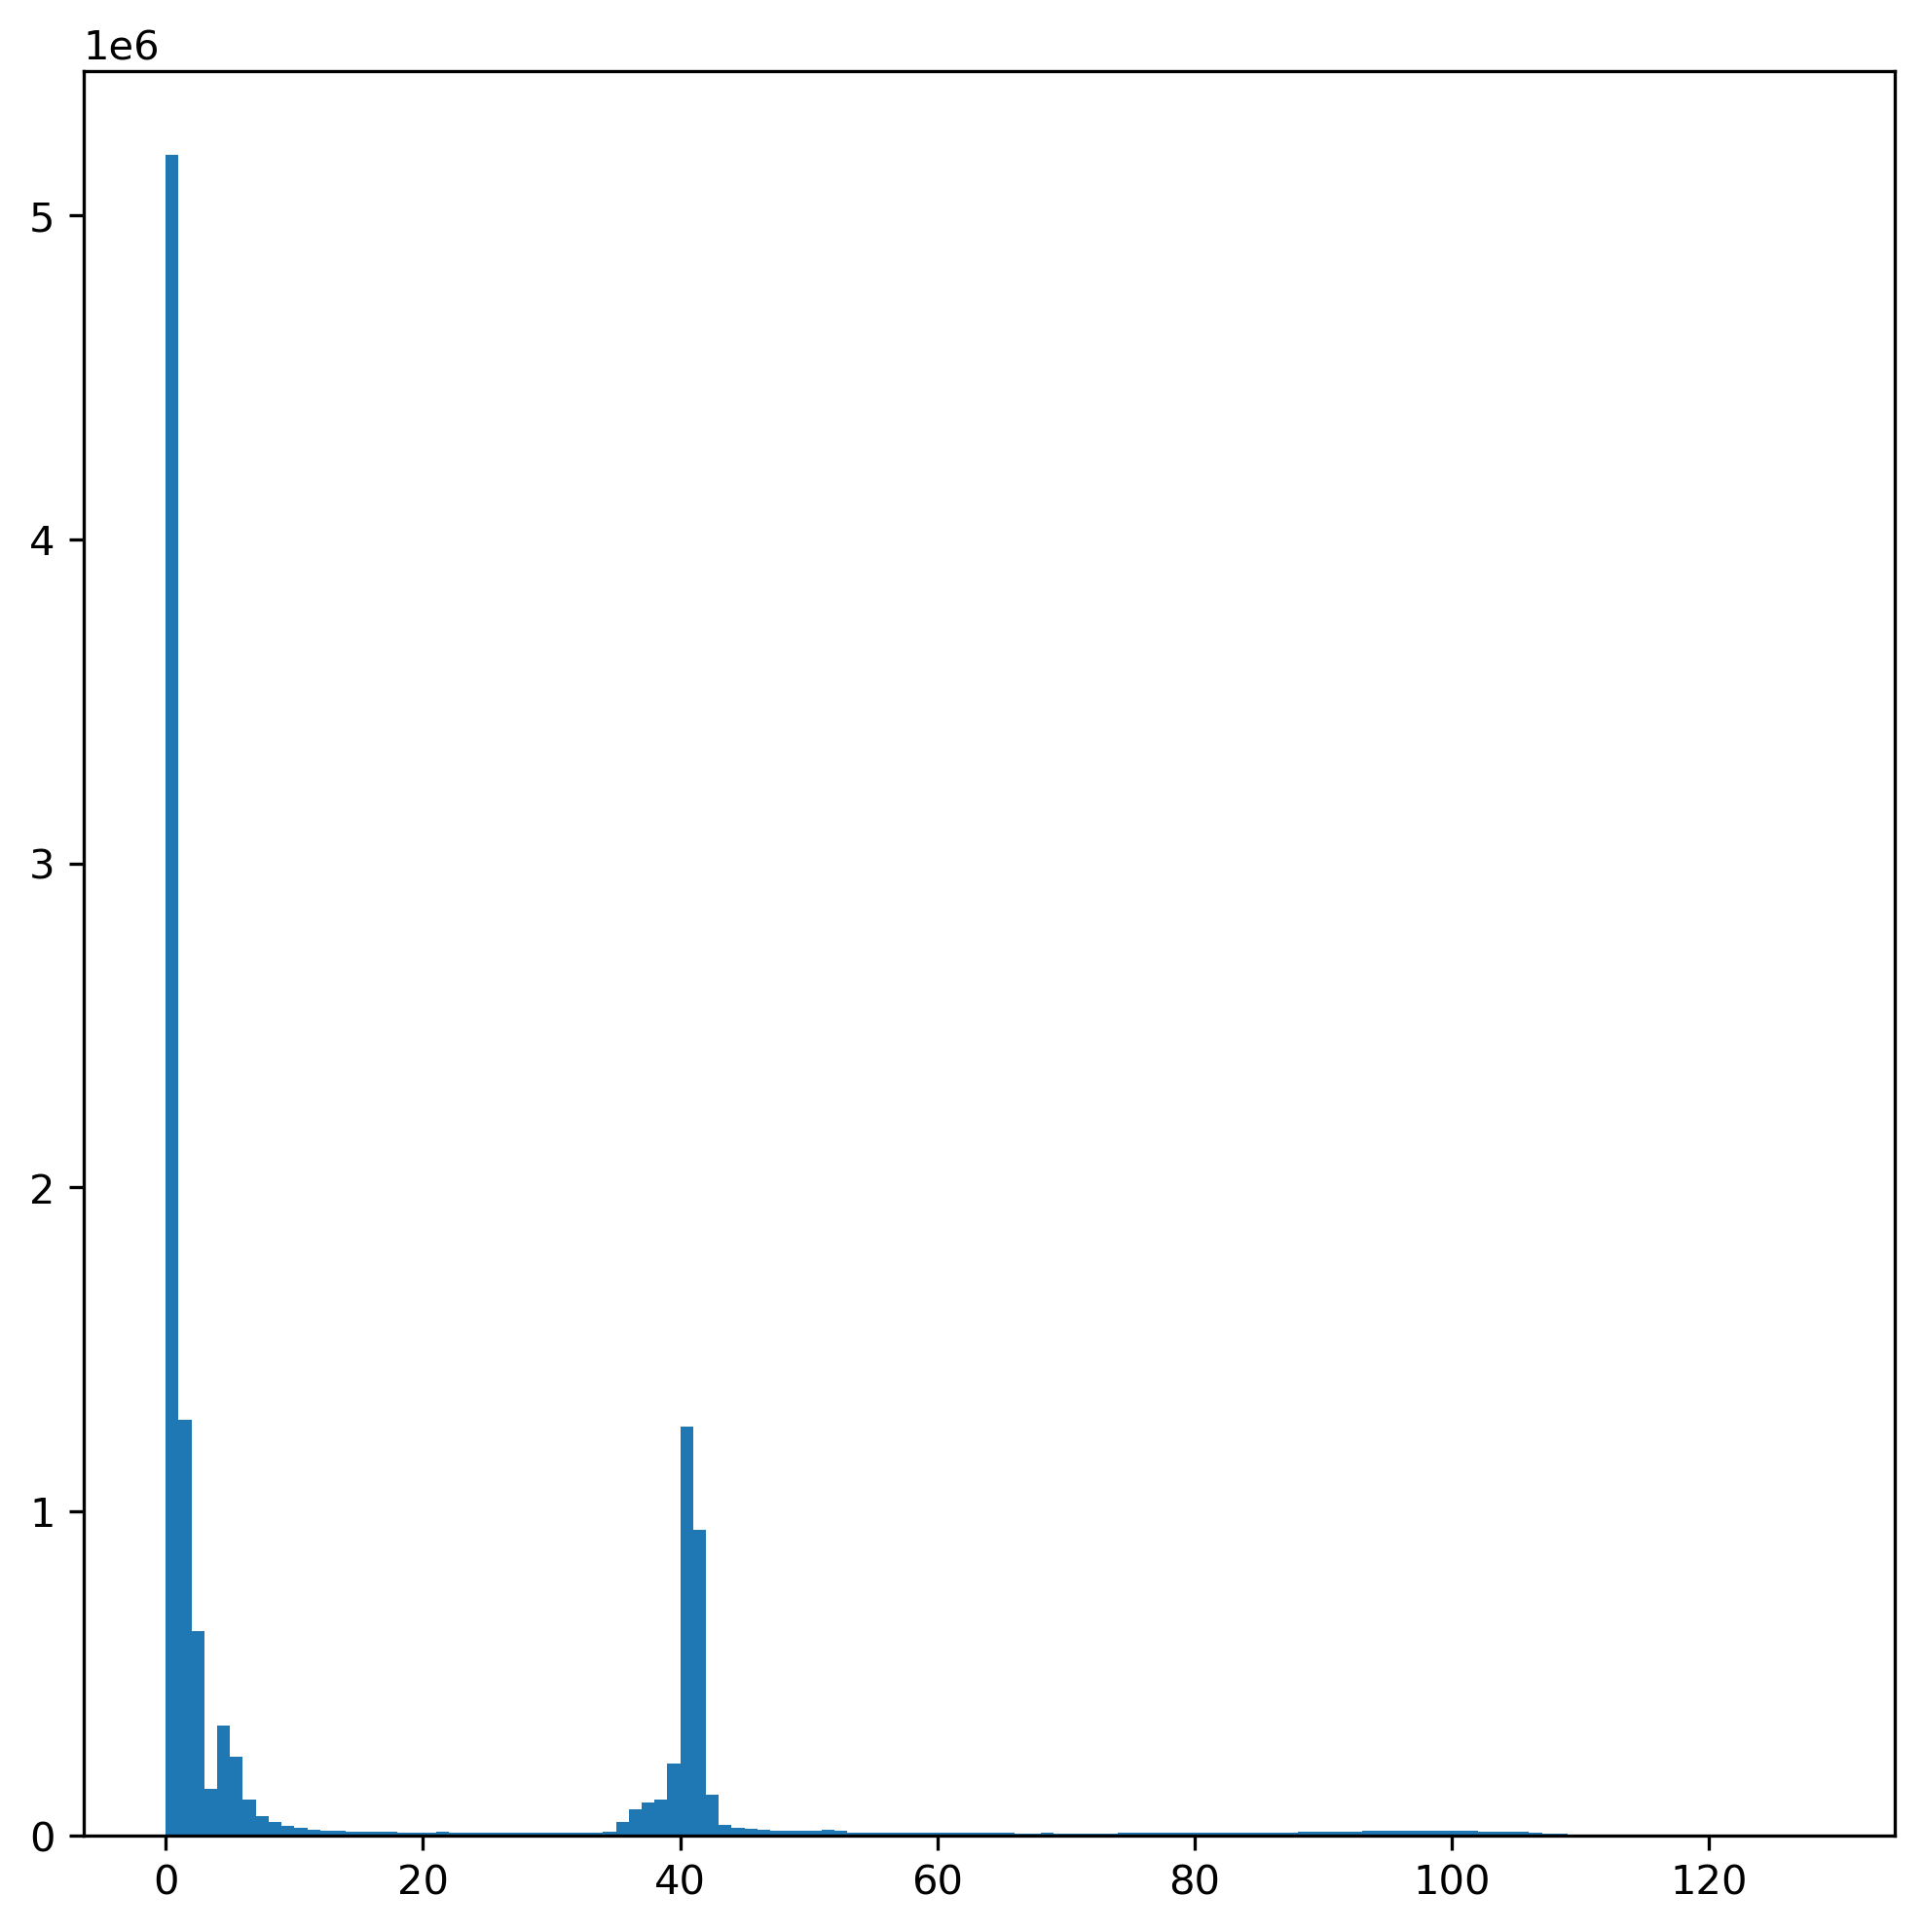

In [77]:
data = np.asarray(list(data_discrete), dtype=np.int64)
plt.figure(figsize=(8, 8), dpi=300)
plt.hist(np.ravel(data_discrete), bins=n_bin)

# Std

In [24]:
n_bin = 128
pixel_corr_std = np.zeros((n_bin, n_bin, len(X_list)))

for cnt_file, file_path in enumerate(X_list):
    file_name = os.path.basename(file_path)
    pixel_corr_std[:, :, cnt_file] = np.load(train_dict["save_folder"]+file_name[:-7]+"_pix_cor.npy")

pixel_corr_std = np.std(pixel_corr_std, axis=2)

loc_x = np.zeros((n_bin)*(n_bin))
loc_y = np.zeros((n_bin)*(n_bin))
pc_ft = np.zeros((n_bin)*(n_bin))
for idx in range(n_bin):
    for idy in range(n_bin):
        flatten = idx*n_bin + idy
        loc_x[flatten] = idx
        loc_y[flatten] = idy
        pc_ft[flatten] = pixel_corr_std[idx, idy]

corr_mat = pd.DataFrame({"X":loc_x, "Y":loc_y, "counts":pc_ft})

plt.figure(figsize=(12, 12), dpi=1200)
g = sns.relplot(
    data=corr_mat,
    x="X", y="Y", hue="counts",
    palette="vlag", hue_norm=(-1, 1), edgecolor=".7",
    height=10, sizes=(50, 250), size_norm=(-.2, .8),
)

# Tweak the figure to finalize
g.set(xlabel="MR", ylabel="CT", aspect="equal")
g.despine(left=True, bottom=True)
g.ax.margins(.02)
for label in g.ax.get_xticklabels():
    label.set_rotation(90)
for artist in g.legend.legendHandles:
    artist.set_edgecolor(".7")

np.save(train_dict["save_folder"]+"std_pix_cor.npy", pixel_corr)
plt.savefig(train_dict["save_folder"]+"std_pix_cor.png")
plt.close()   

<Figure size 14400x14400 with 0 Axes>

In [92]:
import os
import glob
import time
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
from externel import seaborn as sns

def bin_CT(img, n_bins=1024):
#     data_vector = np.ravel(img)
    data_max = np.amax(img)
    data_min = np.amin(img)
    # print(data_max, data_min)
    data_squeezed = (img-data_min)/(data_max-data_min)
    data_extended = data_squeezed * n_bins
    data_discrete = data_extended // 1
#     print(data_discrete.shape)
    return np.asarray(list(data_discrete), dtype=np.int64)

train_dict = {}
train_dict["time_stamp"] = time.strftime("%Y-%m-%d_%H:%M:%S", time.localtime())
train_dict["project_name"] = "pixel_correlation"
train_dict["save_folder"] = "./project_dir/"+train_dict["project_name"]+"/"

train_dict["folder_X"] = "./data_dir/norm_MR/regular/"
train_dict["folder_Y"] = "./data_dir/norm_CT_2/regular/"

X_list = sorted(glob.glob(train_dict["folder_X"]+"*.nii.gz"))
Y_list = sorted(glob.glob(train_dict["folder_Y"]+"*.nii.gz"))

n_bin = 128

for cnt_file, file_path in enumerate(X_list):
     
    file_name = os.path.basename(file_path)
    cube_x_path = file_path
    cube_y_path = train_dict["folder_Y"] + file_name
    print("--->",cube_x_path,"<---")
    cube_x_data = nib.load(cube_x_path).get_fdata()
    cube_y_data = nib.load(cube_y_path).get_fdata()
    len_x, len_y, len_z = cube_x_data.shape
    pixel_corr = np.zeros((n_bin, n_bin))
    
    X_discrete = bin_CT(cube_x_data, n_bins=n_bin-1)
    Y_discrete = bin_CT(cube_y_data, n_bins=n_bin-1)
        
    for ix in range(len_x):
        for iy in range(len_y):
            for iz in range(len_z):
                pixel_corr[X_discrete[ix, iy, iz], Y_discrete[ix, iy, iz]] += 1
    
    for ix in range(n_bin):
        temp_sum = np.sum(pixel_corr[ix, :])
        # print(np.amax(pixel_corr[ix, :]), end="")
        if not temp_sum == 0.0:
            pixel_corr[ix, :] = pixel_corr[ix, :] / np.sum(pixel_corr[ix, :])
        # print(np.amax(pixel_corr[ix, :]))
            
    loc_x = np.zeros((n_bin)*(n_bin))
    loc_y = np.zeros((n_bin)*(n_bin))
    pc_ft = np.zeros((n_bin)*(n_bin))
    for idx in range(n_bin):
        for idy in range(n_bin):
            flatten = idx*n_bin + idy
            loc_x[flatten] = idx
            loc_y[flatten] = idy
            pc_ft[flatten] = pixel_corr[idx, idy]

    corr_mat = pd.DataFrame({"X":loc_x, "Y":loc_y, "counts":pc_ft})

    plt.figure(figsize=(12, 12), dpi=1200)
    g = sns.relplot(
        data=corr_mat,
        x="X", y="Y", hue="counts",
        palette="vlag", hue_norm=(-1, 1), edgecolor=".7",
        height=10, sizes=(50, 250), size_norm=(-.2, .8),
    )

    # Tweak the figure to finalize
    g.set(xlabel="MR", ylabel="CT", aspect="equal")
    g.despine(left=True, bottom=True)
    g.ax.margins(.02)
    for label in g.ax.get_xticklabels():
        label.set_rotation(90)
    for artist in g.legend.legendHandles:
        artist.set_edgecolor(".7")
        
    np.save(train_dict["save_folder"]+file_name[:-7]+"_pix_cor.npy", pixel_corr)
    plt.savefig(train_dict["save_folder"]+file_name[:-7]+"_pix_cor.png")
    plt.close('all')

    pred_file = nib.Nifti1Image(X_discrete, nib.load(cube_x_path).affine, nib.load(cube_x_path).header)
    pred_name = "./data_dir/norm_MR/discrete/"+file_name[:-7]+"_MR_D.nii.gz"
    nib.save(pred_file, pred_name)
    
    pred_file = nib.Nifti1Image(Y_discrete, nib.load(cube_y_path).affine, nib.load(cube_y_path).header)
    pred_name = "./data_dir/norm_CT_2/discrete/"+file_name[:-7]+"_CT_D.nii.gz"
    nib.save(pred_file, pred_name)

---> ./data_dir/norm_MR/regular/NORM_001.nii.gz <---
---> ./data_dir/norm_MR/regular/NORM_002.nii.gz <---
---> ./data_dir/norm_MR/regular/NORM_003.nii.gz <---
---> ./data_dir/norm_MR/regular/NORM_004.nii.gz <---
---> ./data_dir/norm_MR/regular/NORM_005.nii.gz <---
---> ./data_dir/norm_MR/regular/NORM_006.nii.gz <---
---> ./data_dir/norm_MR/regular/NORM_007.nii.gz <---
---> ./data_dir/norm_MR/regular/NORM_008.nii.gz <---
---> ./data_dir/norm_MR/regular/NORM_010.nii.gz <---
---> ./data_dir/norm_MR/regular/NORM_011.nii.gz <---
---> ./data_dir/norm_MR/regular/NORM_012.nii.gz <---
---> ./data_dir/norm_MR/regular/NORM_013.nii.gz <---
---> ./data_dir/norm_MR/regular/NORM_014.nii.gz <---
---> ./data_dir/norm_MR/regular/NORM_015.nii.gz <---
---> ./data_dir/norm_MR/regular/NORM_017.nii.gz <---
---> ./data_dir/norm_MR/regular/NORM_018.nii.gz <---
---> ./data_dir/norm_MR/regular/NORM_019.nii.gz <---
---> ./data_dir/norm_MR/regular/NORM_020.nii.gz <---
---> ./data_dir/norm_MR/regular/NORM_022.nii.g